# Computer Vision Task

In [1]:
import requests
import os
from tqdm import tqdm
from multiprocessing import Pool
from functools import partial
import shutil
from pathlib import Path

from PIL import Image, ImageFile
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import timm
from torchmetrics.classification import BinaryAUROC
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

/home/claude/miniconda3/envs/coct/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Skip to the tensorboard logs
Running this whole file can take a while. You can skip to the tensorboard logs by spinning up a tensorboard session and using the lightning_logs directory. Then go to localhost:6006 in your browser. 

pip install tensorboard

tensorboard --logdir lightning_logs

## Download the images

We will download the images to a subdirectory called 'train'. 
Inside train there are two directories, one for the "yes" samples and another for "no".
Then we will move a small subset of the images to a 'test' subdirectory for the test set.

In [8]:
os.makedirs("images/swimming-pool/train/yes")
os.makedirs("images/swimming-pool/train/no")

os.makedirs("images/swimming-pool/test/yes")
os.makedirs("images/swimming-pool/test/no")

In [4]:
def download_file(url, filename, verbose=True):
    try:
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        response.raise_for_status()  # Raises an HTTPError for bad responses
        
        with open(filename, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        
        if verbose:
            print(f"Downloaded: {filename}")
        return True
    
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return False

def download_file_parallel(args):
    """Wrapper function for multiprocessing - takes a tuple of (url, filename)"""
    url, filename = args
    return download_file(url, filename, verbose=False)

In [9]:
# Download the manifest files

download_file("https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/images/swimming-pool/yes/manifest", "images/swimming-pool/train/yes/manifest")
download_file("https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/images/swimming-pool/no/manifest", "images/swimming-pool/train/no/manifest")

Downloaded: images/swimming-pool/train/yes/manifest
Downloaded: images/swimming-pool/train/no/manifest


True

### Downloading images is slow
Downloading the images. I use 4 parallel processes to try download them faster, but it still takes a while (30min).
There is probably a better way to do this.

In [12]:
# Download 'yes' images in parallel
print("Downloading 'yes' images...")
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/images/swimming-pool/yes/"
download_args = []

with open("images/swimming-pool/train/yes/manifest", "r") as file:
    for line in file:
        filename = line.strip()
        filename = filename.split("/")[-1]
        url = base_url + filename
        local_path = f"images/swimming-pool/train/yes/{filename}"
        download_args.append((url, local_path))

# Download with 4 parallel processes
with Pool(processes=4) as pool:
    results = list(pool.map(download_file_parallel, download_args))

print(f"Successfully downloaded {sum(results)} out of {len(download_args)} 'yes' images")

KeyboardInterrupt: 

In [ ]:
# Download 'no' images in parallel
print("\nDownloading 'no' images...")
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/images/train/swimming-pool/no/"
download_args = []

with open("images/swimming-pool/train/no/manifest", "r") as file:
    for line in file:
        filename = line.strip()
        filename = filename.split("/")[-1]
        url = base_url + filename
        local_path = f"images/swimming-pool/train/no/{filename}"
        download_args.append((url, local_path))

# Download with 4 parallel processes
with Pool(processes=4) as pool:
    results = list(pool.map(download_file_parallel, download_args))

print(f"Successfully downloaded {sum(results)} out of {len(download_args)} 'no' images")

In [ ]:
# Move some images to the test set.
# we will move 50 yes images and 50 no images to make the test set balanced.

# first delete the manifest files if they still exist
if os.path.exists('images/swimming-pool/train/yes/manifest'):
    os.remove('images/swimming-pool/train/yes/manifest')
if os.path.exists('images/swimming-pool/train/no/manifest'):
    os.remove('images/swimming-pool/train/no/manifest')

# Paths
train_yes_dir = 'images/swimming-pool/train/yes'
train_no_dir  = 'images/swimming-pool/train/no'
test_yes_dir  = 'images/swimming-pool/test/yes'
test_no_dir   = 'images/swimming-pool/test/no'

def move_random_samples(src_dir, dst_dir, k=50):
    # list all files
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    # pick first 50
    for fname in files[:50]:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        shutil.move(src, dst)
    print(f"Moved {50} files from {src_dir} to {dst_dir}")

# Move 50 from train/yes → test/yes
move_random_samples(train_yes_dir, test_yes_dir, k=50)
# Move 50 from train/no → test/no
move_random_samples(train_no_dir,  test_no_dir,  k=50)

### Some images a broken
Some of the images are broken. A list of them is included in 'broken_images_log.txt'. 
So we will delete those from the images file. 

In [2]:

broken_images = [
    'W34B_22_85.tif',
    'W34D_18_19.tif',
    'W34D_21_93.tif',
    'W34C_24_80.tif',
    'W34D_3_69.tif',
    'W34D_15_72.tif',
    'W34D_24_69.tif',
    'W35A_10_43.tif',
    'W34D_11_27.tif',
    'W34D_1_100.tif',
    'W34D_13_46.tif',
    'W35A_12_53.tif',
    'W34B_25_74.tif',
    'W34C_19_63.tif',
    'W34C_21_78.tif'
]

# Check and delete broken images from train directories
for broken_img in broken_images:
    # Check in train/yes directory
    yes_path = os.path.join('images/swimming-pool/train/yes', broken_img)
    if os.path.exists(yes_path):
        os.remove(yes_path)
        print(f"Deleted broken image from train/yes: {broken_img}")
    
    # Check in train/no directory  
    no_path = os.path.join('images/swimming-pool/train/no', broken_img)
    if os.path.exists(no_path):
        os.remove(no_path)
        print(f"Deleted broken image from train/no: {broken_img}")

Deleted broken image from train/yes: W34B_22_85.tif
Deleted broken image from train/yes: W34D_18_19.tif
Deleted broken image from train/yes: W34D_21_93.tif
Deleted broken image from train/yes: W34C_24_80.tif
Deleted broken image from train/yes: W34D_3_69.tif
Deleted broken image from train/yes: W34D_15_72.tif
Deleted broken image from train/yes: W34D_24_69.tif
Deleted broken image from train/yes: W35A_10_43.tif
Deleted broken image from train/yes: W34D_11_27.tif
Deleted broken image from train/yes: W34D_1_100.tif
Deleted broken image from train/yes: W34D_13_46.tif
Deleted broken image from train/yes: W35A_12_53.tif
Deleted broken image from train/yes: W34B_25_74.tif
Deleted broken image from train/yes: W34C_19_63.tif
Deleted broken image from train/yes: W34C_21_78.tif


### Convert from tif to png

The tif files were causing some issues for me so I bulk onverted them to PNG before training. But this takes some time.


In [ ]:
# allow Pillow to load truncated TIFFs
ImageFile.LOAD_TRUNCATED_IMAGES = True

os.makedirs("images/swimming-pool/png", exist_ok=True)

input_dir  = Path("images/swimming-pool/")
output_dir = Path("images/swimming-pool/png")

for tif_path in input_dir.rglob("*.tif"):
    # compute the sub-path under input_dir, e.g. "subdir1/subdir2"
    rel_subdir = tif_path.parent.relative_to(input_dir)
    # make the corresponding directory under output_dir
    target_subdir = output_dir / rel_subdir
    target_subdir.mkdir(parents=True, exist_ok=True)

    # load (with fallback)
    try:
        img = Image.open(tif_path).convert("RGB")
    except (OSError, IOError):
        arr = tifffile.imread(tif_path)
        img = Image.fromarray(arr).convert("RGB")

    # choose your format & settings:
    out_path = target_subdir / (tif_path.stem + ".png")
    img.save(out_path, compress_level=6)


## Data Loader

We now make a pytorch lightning data loader. It will handle splitting our data into a train (80%) and validation set (20%).
It will also keep the test set seperate. 
We will create some data transforms. In Particular we will resize the image, apply random flips and rotations and finally normalise the pixel values. 

In [44]:
class DataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "images/swimming-pool/png", batch_size: int = 32, img_size: int = 224):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
            transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
        ])

    def setup(self, stage=None):
        full = datasets.ImageFolder(os.path.join(self.data_dir, "train"), transform=self.transform)
        n = len(full)
        val_size = int(0.2 * n)
        train_size = n - val_size
        self.train_set, self.val_set = random_split(full, [train_size, val_size])
        self.test_set = datasets.ImageFolder(os.path.join(self.data_dir, "test"), transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=2, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=2, persistent_workers=True)

In [45]:
dm = DataModule(data_dir="images/swimming-pool/png", batch_size=64, img_size=224)

## First Model
The first model attempt will be a simple CNN trained from scratch.
It includes convolution layers, non-linear activations, max pooling and a series of dense linear at the end for the output.

Since this is a binary classification task we need only a single unit for the output (prob of positive sample). We use the binary cross-entropy loss.

Since the classes in the dataset are imbalanced we can also apply some reweighting to correct for that. There are roughly twice as many positive samples as negative, so we use a pos_weight of 0.5. 

In [46]:
class ScratchCNN(L.LightningModule):
    def __init__(self, lr=1e-3, pos_weight=1.0, img_size=224):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * (img_size//8)**2, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.auroc = BinaryAUROC()

    def forward(self, x):
        return self.net(x).squeeze(1)

    def step(self, batch, stage):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.float())
        preds = torch.sigmoid(logits)
        auc = self.auroc(preds, y.int())
        self.log(f"{stage}_loss", loss, prog_bar=True)
        self.log(f"{stage}_auc", auc, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self.step(batch, "val")

    def test_step(self, batch, batch_idx):
        self.step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

### Train loop
Here we train the model. We use early stopping on the validation set accuracy. So if the model does not improve over 3 epochs, training will stop and the best model will be checkpointed.

The training loop took around 20min on my laptop that has a GPU.

In [47]:
model = ScratchCNN(lr=1e-3, pos_weight=0.5, img_size=224)

checkpoint = ModelCheckpoint(monitor="val_auc", mode="max")
early_stop = EarlyStopping(monitor="val_auc", mode="max", patience=3)
tb_logger = TensorBoardLogger("logs")

trainer = Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    precision=16,
    callbacks=[checkpoint, early_stop],
)

trainer.fit(model, dm)
trainer.test(model, dm)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | net     | Sequential        | 6.4 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | auroc   | BinaryAUROC       | 0      | train
------------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.785    Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 29: 100%|██████████| 87/87 [00:55<00:00,  1.57it/s, v_num=2, train_loss=0.107, train_auc=0.986, val_loss=0.125, val_auc=0.978] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 87/87 [00:55<00:00,  1.57it/s, v_num=2, train_loss=0.107, train_auc=0.986, val_loss=0.125, val_auc=0.978]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 15.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_auc            0.6445833444595337
        test_loss           0.2539096474647522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2539096474647522, 'test_auc': 0.6445833444595337}]

### Model 2
For our imporved next attempt, we will use a pre-trained image model from timm and finetune it for our task. 
We will use a ResNet pretrained on image net. This will give us the benefit of the model already having learnt usefull feature representations. 

Through experimenting I actually found data augmentation hurt the performance of the pretrained model on the test set. So we create a new data loader without the augmentation.

In [41]:
class DataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "images/swimming-pool/png", batch_size: int = 32, img_size: int = 224):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            # transforms.RandomHorizontalFlip(0.5),
            # transforms.RandomVerticalFlip(0.5),
            # transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485,.456,.406], std=[.229,.224,.225]),
        ])

    def setup(self, stage=None):
        full = datasets.ImageFolder(os.path.join(self.data_dir, "train"), transform=self.transform)
        n = len(full)
        val_size = int(0.2 * n)
        train_size = n - val_size
        self.train_set, self.val_set = random_split(full, [train_size, val_size])
        self.test_set = datasets.ImageFolder(os.path.join(self.data_dir, "test"), transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=2, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=2, persistent_workers=True)
    


# Instantiate the data module
dm = DataModule(data_dir="images/swimming-pool/png", batch_size=64, img_size=224)

In [42]:
class PretrainedResNet(ScratchCNN):
    def __init__(self, backbone_name="efficientnet_b0", lr=3e-4, pos_weight=1.0):
        super().__init__(lr=lr, pos_weight=pos_weight)
        # Override the feature extractor:
        self.net = timm.create_model(
            backbone_name, pretrained=True, num_classes=1
        )
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.auc = BinaryAUROC()

In [43]:
model = PretrainedResNet(
    backbone_name="resnet34", 
    lr=1e-4, 
    pos_weight=0.5
)

checkpoint = ModelCheckpoint(monitor="val_auc", mode="max")
early_stop = EarlyStopping(monitor="val_auc", mode="max", patience=3)
tb_logger = TensorBoardLogger("logs")

trainer = Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    precision=16,
    callbacks=[checkpoint, early_stop],
)

trainer.fit(model, dm)
trainer.test(model, dm)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | net     | ResNet            | 21.3 M | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | auroc   | BinaryAUROC       | 0      | train
3 | loss    | BCEWithLogitsLoss | 0      | train
4 | auc     | BinaryAUROC       | 0      | train
------------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.141    Total estimated model params size (MB)
170       Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 87/87 [00:56<00:00,  1.53it/s, v_num=1, train_loss=0.00494, train_auc=1.000, val_loss=0.166, val_auc=0.969]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 27.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_auc            0.6833332777023315
        test_loss           0.3433762192726135
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/claude/miniconda3/envs/coct/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


[{'test_loss': 0.3433762192726135, 'test_auc': 0.6833332777023315}]

### Check the results in tensorboard 

In [49]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs --port 6007

Reusing TensorBoard on port 6007 (pid 1344766), started 0:00:28 ago. (Use '!kill 1344766' to kill it.)

### Qualitative Check
We will load 5 positive and 5 negative samples, visualise them and show the model predictions vs true lables.

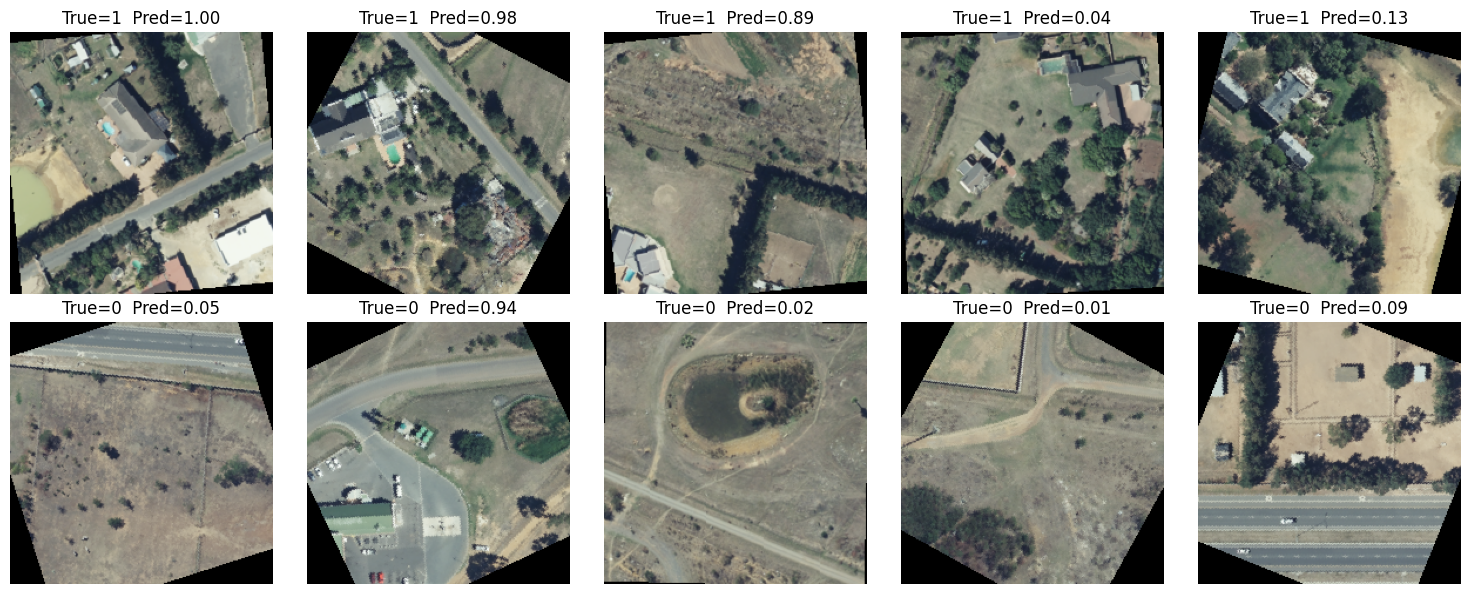

In [50]:
test_ds = dm.test_set  
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. find 5 positives and 5 negatives
pos_idxs, neg_idxs = [], []
for i, (_, label) in enumerate(test_ds):
    if   label == 1 and len(pos_idxs) < 5: pos_idxs.append(i)
    elif label == 0 and len(neg_idxs) < 5: neg_idxs.append(i)
    if len(pos_idxs) == 5 and len(neg_idxs) == 5:
        break
sample_idxs = pos_idxs + neg_idxs

# 3. helper to un-normalize a tensor image
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
def unnormalize(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    img = img * std + mean
    return np.clip(img, 0, 1)

# 4. plot in a 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for row, idxs in enumerate([pos_idxs, neg_idxs]):
    for col, idx in enumerate(idxs):
        img, label = test_ds[idx]
        x = img.unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(x)
            prob   = torch.sigmoid(logits)[0].item()

        ax = axes[row, col]
        ax.imshow(unnormalize(img))
        ax.set_title(f"True={label}  Pred={prob:.2f}")
        ax.axis("off")

plt.tight_layout()
plt.show()

## Improving the model
We probably scaled down the size of the image too much for very good accuracy. To imrpove, we could re-run everything on larger images. Due to computational constraints, this was not possible now.